## Business Problem
1. To develop a model for ACME Real Estate Agency to accurately predict a value of a house based on avaliable data. This will help their clients, either buy or sell their homes at a fair price.
2. To identify if renovations can be made to improve the selling price of the house.

## Methodology
By developing using a Linear Regression model, we will try to predict the selling price of a house based on attributes like size, number of bedrooms/bathroorms etc. WE will also try to minimize the RMSE value to achieve maximum efficiency.

## Dataset
Dataset used will be the King County House Sales dataset : `kc_house_data.csv`

## EDA

In [39]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#for reading spatial data
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [2]:
#importing files
#getting the file from the github repo
url = 'https://raw.githubusercontent.com/rahulakrish/real_estate_analysis/main/kc_house_data.csv'
df = pd.read_csv(url)

#checking the df
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


Let's visualize the listings on a map. This can be done using the `geopandas` library.

In [33]:
#creating a copy of the df
mapdf = df.copy()

#reading the shapefile of Kings County
king_map = gpd.read_file('Addresses_in_King_County___address_point.shp')

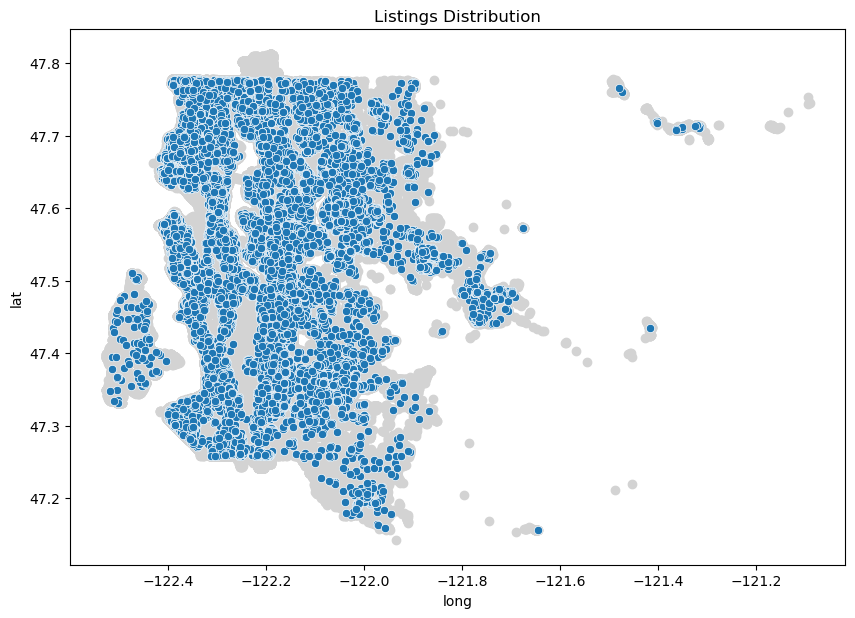

In [67]:
#defining the co-ordinate system
crs = {'init': 'EPSG:4326'}

#setting up points
geometry = [Point(xy) for xy in zip(mapdf['long'],mapdf['lat'])]
geo_df = gpd.GeoDataFrame(mapdf,
                         crs=crs,
                         geometry=geometry)

#plotting data
fig,ax=plt.subplots(figsize=(10,10))
king_map.to_crs(epsg=4326).plot(ax=ax,color='lightgrey')
sns.scatterplot(x='long',y='lat',data=mapdf,ax=ax)
ax.set_title('Listings Distribution');

Gathering some info about the df:

In [4]:
print(f'Size of the dataframe is {df.shape}')
print('\n')
df.info()

Size of the dataframe is (21613, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat        

We can see that there is a reasonable amount of data for us to work with.

In [5]:
#dropping the id column since it is irrelevant
df.drop(columns=['id','date'],axis=1,inplace=True)

# #converting the date to date format
# df['date'] = pd.to_datetime(df['date'])

Checking for missing data:

In [6]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

We can impute the median for the missing values in sqft_above. Since median is the actual mid-point of the data and unaffected by outlliers, it is a safe choice:

In [7]:
#getting the median
median = df['sqft_above'].median()

#imputing the median value
df['sqft_above'].fillna(median,inplace=True)

#checking to see if it workedb
df.isna().sum().value_counts()

0    19
dtype: int64

Let's check how the different features look like.This can be done with a simple line of code using Pandas:

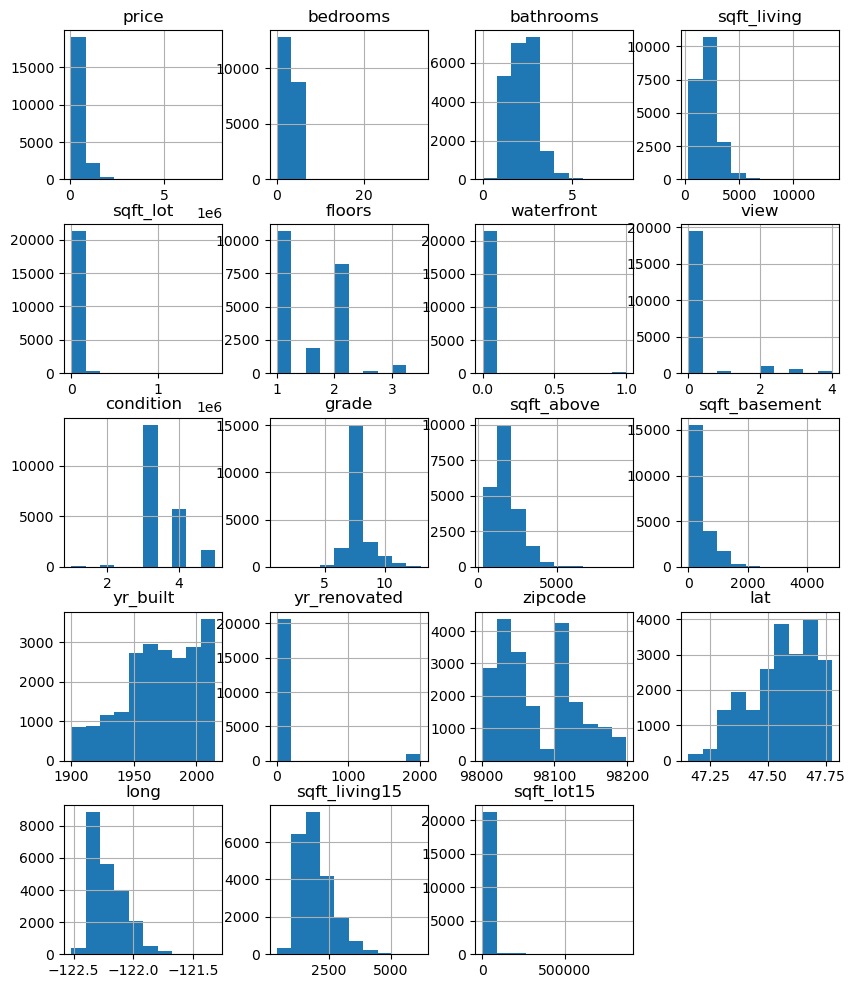

In [8]:
pd.plotting.hist_frame(df,figsize=(10,12));

Couple of things to note from the plot:
1. None of the features are normally distributed.
2. The magnitiudes between the features differs considerably. Left unchanged, this would cause the co-efficients to fluctuate as well. This could lead to false impressions that some features are more important than others.

### Scaling the data

Let's scale the data first. This can be done by using the MinMaxScaler class from sklearn. Having all values on the same scale helps improve model performance.

In [9]:
#importing the class from sklearn
from sklearn.preprocessing import MinMaxScaler

#instantiating
scaler = MinMaxScaler()

#applying the scaler to the df
df2 = scaler.fit_transform(df)

#since the scaler returns arrays, let's create a new df 
df2 = pd.DataFrame(df2,columns=df.columns)

df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.019266,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,0.500000,0.097588,0.000000,0.478261,0.000000,0.893939,0.571498,0.217608,0.161934,0.005742
1,0.060721,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,0.500000,0.206140,0.082988,0.443478,0.988089,0.626263,0.908959,0.166113,0.222165,0.008027
2,0.013770,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,0.416667,0.052632,0.000000,0.286957,0.000000,0.136364,0.936143,0.237542,0.399415,0.008513
3,0.069377,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,0.500000,0.083333,0.188797,0.565217,0.000000,0.681818,0.586939,0.104651,0.165376,0.004996
4,0.057049,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,0.583333,0.152412,0.000000,0.756522,0.000000,0.368687,0.741354,0.393688,0.241094,0.007871


We can see all the values are between 0 and 1.

## Linear Regression using sklearn

Since the price of the house is what we're looking to predict, it becomes the dependent variable - y and the rest of the features in the dataset are the independent variables - x. 

In [18]:
#setting up X and y for regression analysis
y = df2.loc[:,'price']
X = df2.drop('price',axis=1)

#setting up train-test-splits
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=23)

#importing the linear regression from sklearn
from sklearn.linear_model import LinearRegression

#instantiating
model = LinearRegression()

#fitting the model
model.fit(X_train,y_train)

### Model evaluation

Model performance can be evaluated using the score method. Default metric used is the R-squared value which calculates the goodness of fit of the regression model. The R-squared value falls between 0 and 1. Values that are closer to 1 indicate a better fit.

In [19]:
round(model.score(X_test,y_test),3)

0.701

This is interpreted as : 70.1% of the variation in the dependent variable, in our case the price of a house can be explained by the independent variables i.e sqft size, number of bedrooms etc.

Clearly, there is room for improvement.